# Mixtures of MCs -- Testbed

In [1]:
import sys
# setting path
sys.path.append('../core')

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-03-18 19:10:37.037690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 19:10:37.088342: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 19:10:37.337292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-18 19:10:37.337318: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
genres = pd.read_csv('Lastfm-ArtistTags2007/tags.txt', header=None)[0].values[:100]
genres = pd.DataFrame([genre.split()[0] for genre in genres], 
             index = [' '.join(genre.split()[1:]) for genre in genres],
            columns = ['count'])
genres.head()

,count
rock,440854
seen live,343901
indie,277747
alternative,245259
metal,184491


In [3]:
users = pd.read_csv("lastfm-dataset-1K/userid-profile.tsv", sep="\t")
users.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [4]:
lastfm = pd.read_csv("lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", sep="\t", 
           header=None, on_bad_lines='skip')
lastfm.columns = ['userid', 'timestamp', 'artistid', 'artistname', 'trackid', 'trackname']
topusers = lastfm.groupby('userid').size().sort_values()[-10:]
lastfm = lastfm[[user in topusers for user in lastfm['userid']]]
lastfm.timestamp = pd.to_datetime(lastfm['timestamp'])

In [5]:
tags = pd.read_table('Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')
tags.columns = ['artistid', 'artistname', 'tagname', 'rawtagcount']
tags = tags[[tag in genres.index for tag in tags['tagname']]]
# there are multiple tags/genres assigned to each artist.
#  for simplicity, pick the tag/genre most associated with each artist
#  by ranking by raw tag count and picking the first
tags = tags[tags.groupby(['artistid', 'artistname'])['rawtagcount'].rank(method='first', ascending=False) <= 1]

In [6]:
dataset = lastfm.merge(tags, on='artistid').sort_values(['userid', 'timestamp'])[['userid', 'timestamp', 'tagname']].reset_index()
# assigning numbers to genres. doing so by ranking genres by how popular they are
tagdict = dict(zip(genres.index.values, np.arange(len(genres))))
dataset['tagnum'] = dataset['tagname'].replace(tagdict)
# for some reason, gupta et al only consider the transitions that change genre
#  we do so here
keeps = (dataset.tagname != dataset.tagname.shift()) * (dataset.userid == dataset.userid.shift())
keeps[0] = True
dataset = dataset[keeps]

In [7]:
nStates = len(genres)
nActions = 1
K = len(topusers)
horizon = 40
N = 3000
numTrajPerK = int(N/horizon)
nTraj = numTrajPerK * K

In [8]:
np.array([dataset[dataset.userid == user].tagnum.values[:N] 
          for user in topusers.index.sort_values()]).shape

(25, 3000)

In [8]:
#gupta et al only keep first 3000 transitions
#building array of one hots
states = np.array([dataset[dataset.userid == user].tagnum.values[:N] 
          for user in topusers.index.sort_values()])
nextstates = np.array([dataset[dataset.userid == user].tagnum.values[1:N+1] 
          for user in topusers.index.sort_values()])
onehots = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][:N] 
          for user in topusers.index.sort_values()])
onehotsp = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][1:N+1] 
          for user in topusers.index.sort_values()])

#splitting into trajectories of length horizon
states = np.array(np.split(states, numTrajPerK, axis=1)).transpose(1,0,2)
nextstates = np.array(np.split(nextstates, numTrajPerK, axis=1)).transpose(1,0,2)
onehots = np.array(np.split(onehots, numTrajPerK, axis=1)).transpose(1,0,2,3)
onehotsp = np.array(np.split(onehotsp, numTrajPerK, axis=1)).transpose(1,0,2,3)

print('shape of states before concat first axis:', states.shape)
print('shape of onehots before concat first axis:', onehots.shape)
#why concatenate? want 0,..,0,1...,1,...,9...,9
labels = np.concatenate([np.ones(numTrajPerK)*k for k in range(K)])
states = np.concatenate(states)
nextstates = np.concatenate(nextstates)
onehots = np.concatenate(onehots)
onehotsp = np.concatenate(onehotsp)
print('shape of states after concat first axis:', states.shape)
print('shape of onehots after concat first axis:', onehots.shape)

#shuffling
inds = np.arange(len(labels))
np.random.shuffle(inds)
labels = labels[inds]
states = states[inds]
onehots = onehots[inds]
onehotsp = onehotsp[inds]

shape of states before concat first axis: (10, 75, 40)
shape of onehots before concat first axis: (10, 75, 40, 100)
shape of states after concat first axis: (750, 40)
shape of onehots after concat first axis: (750, 40, 100)


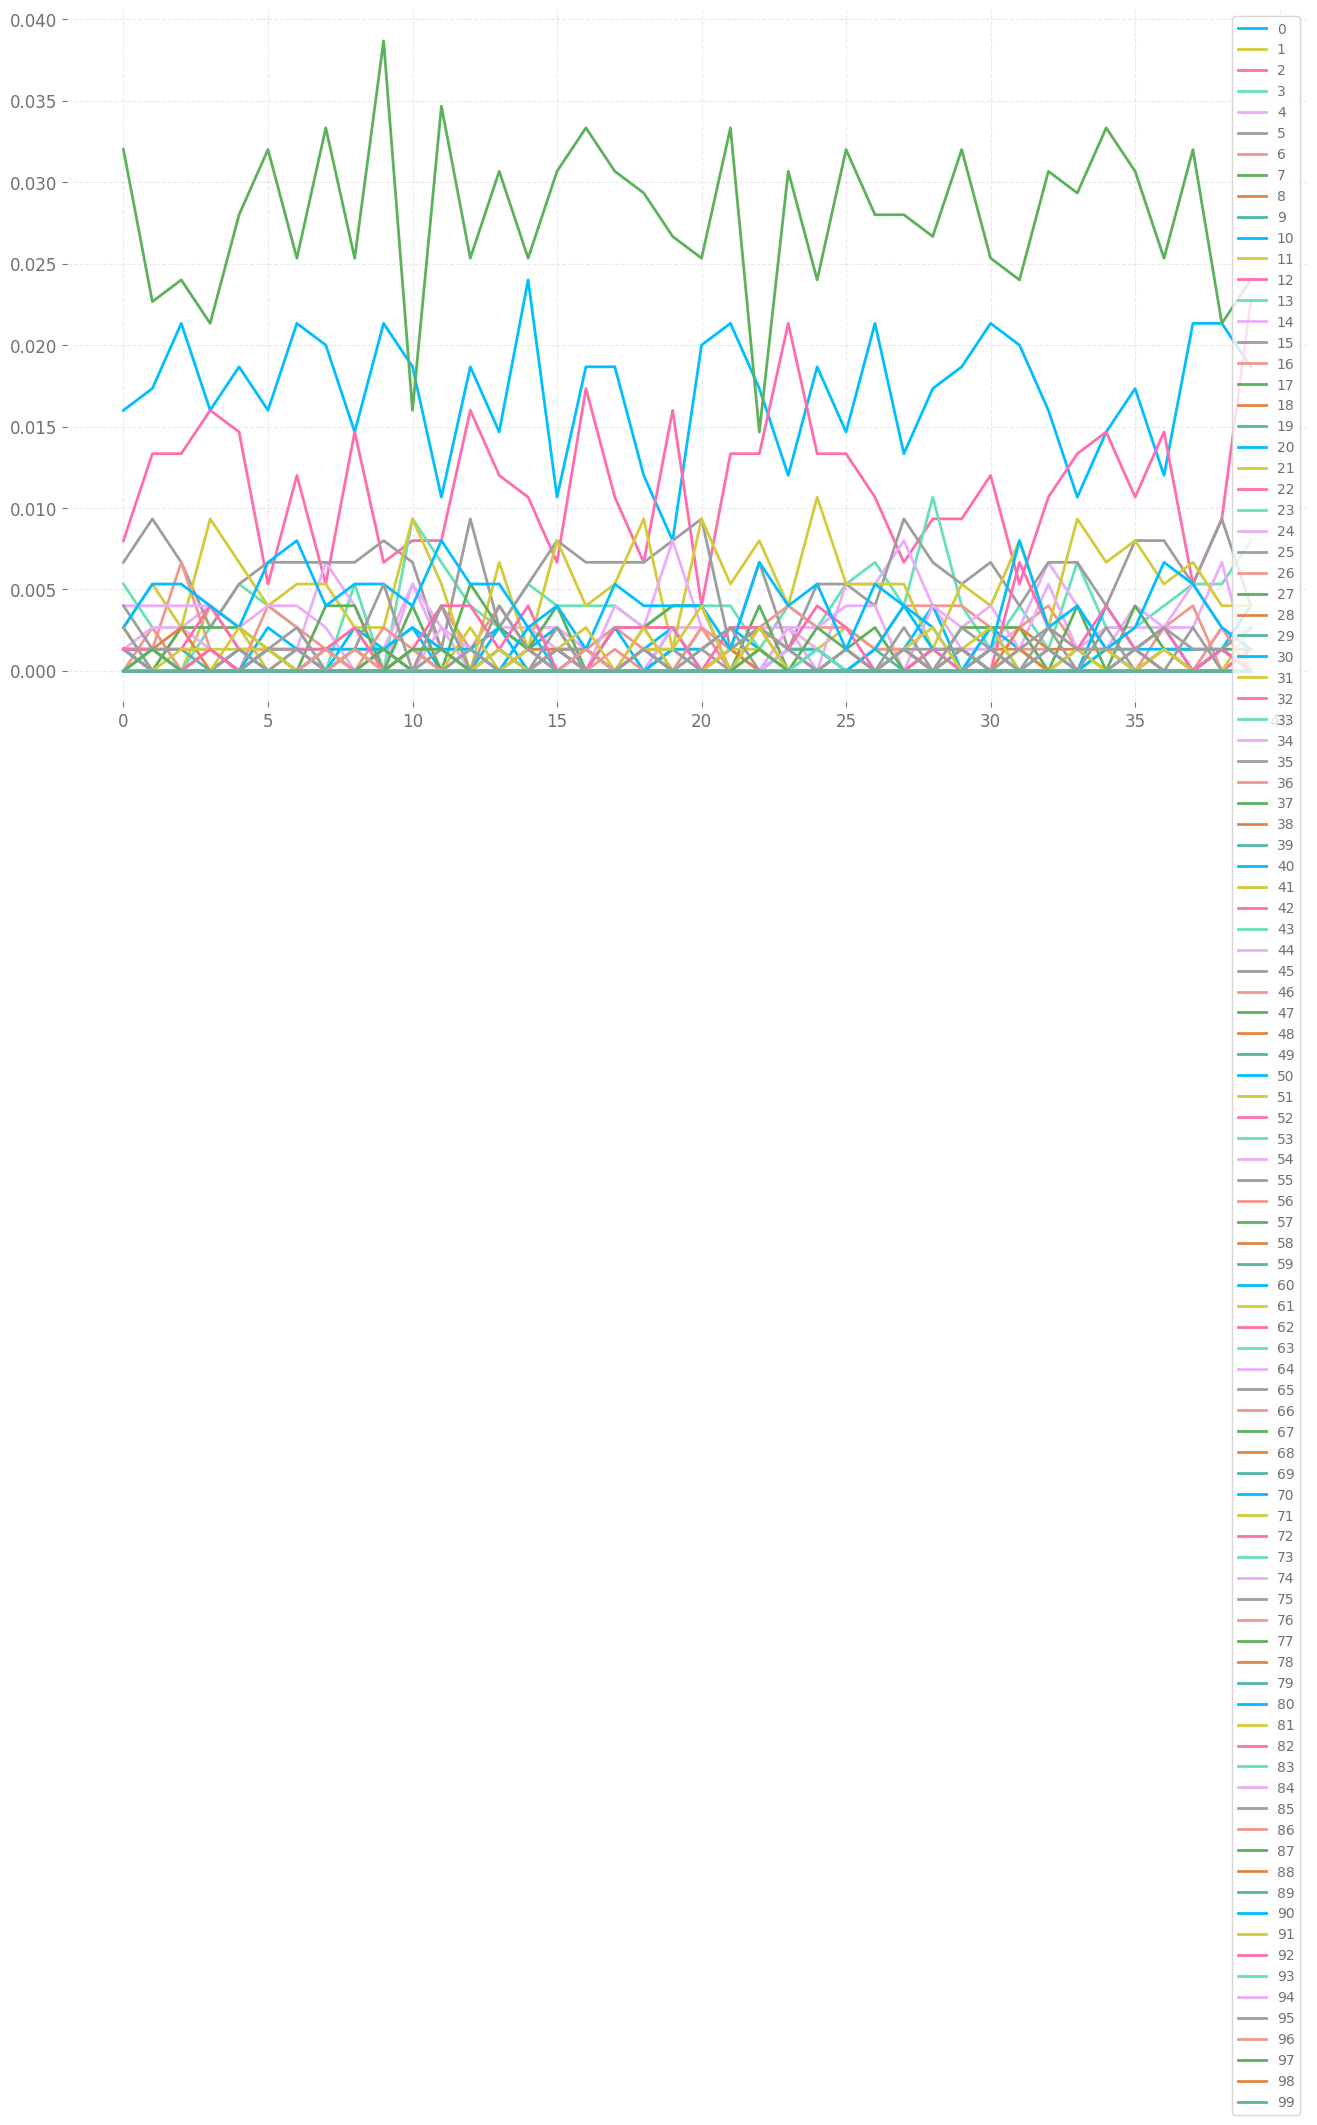

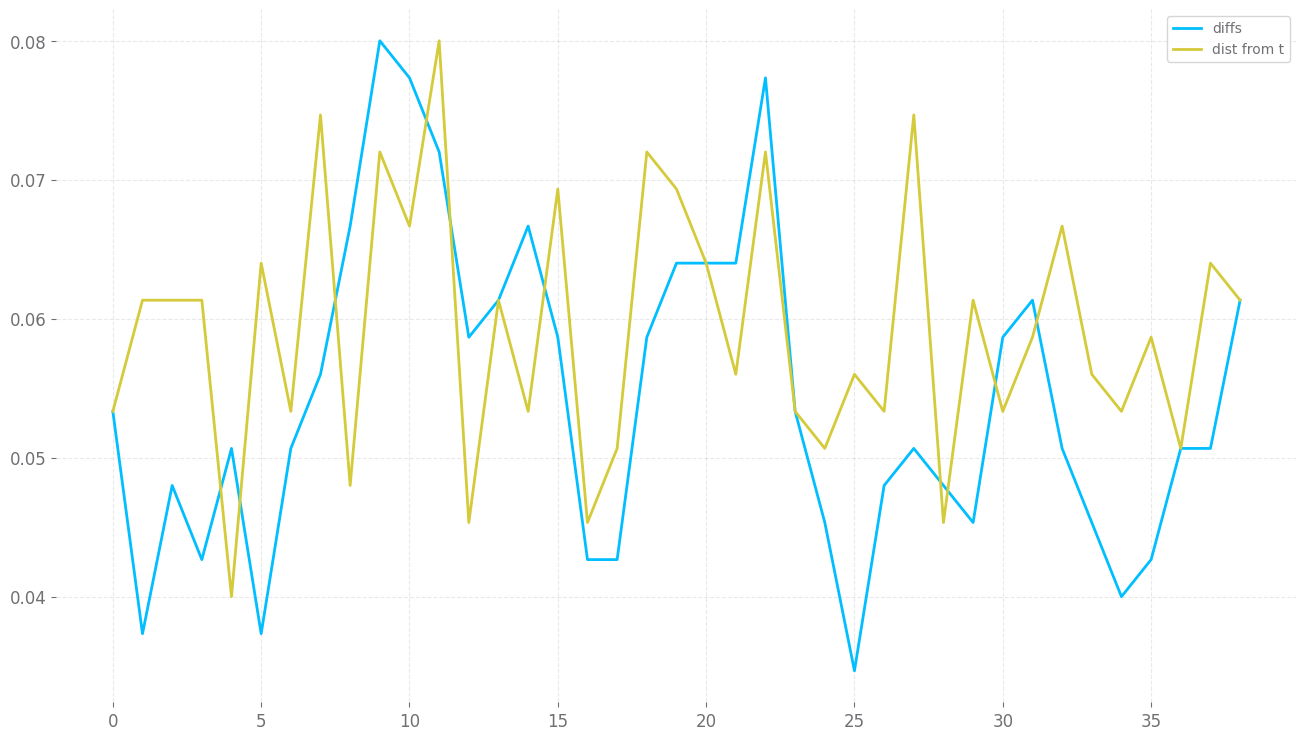

In [9]:
dist = np.array([np.bincount(states[labels==0,i].astype(int), minlength=nStates) 
         for i in range(states.shape[1])])/len(labels)
pd.DataFrame(dist).plot(figsize=(16,9))

plt.figure(figsize=(16,9))
plt.plot(np.sum(np.abs(np.diff(dist, axis=0)),1), label='diffs')
plt.plot(np.sum(np.abs(dist - dist[-1])[:-1],1), label='dist from t')
plt.legend()

In [9]:
sadim = nStates*nActions
spdim = nStates
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
onehotsa = onehots[...,None]
sz = int(onehotsa.shape[0]/3)

In [10]:
onehotsasub = onehotsa[:sz]
onehotspsub = onehotsp[:sz]
onehotsaclust = onehotsa[sz:]
onehotspclust = onehotsp[sz:]

In [11]:
eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K, wt=True)
eigvalsp, eigvecsp = getEigKs(onehotsasub, onehotspsub, omegaone, omegatwo, K)

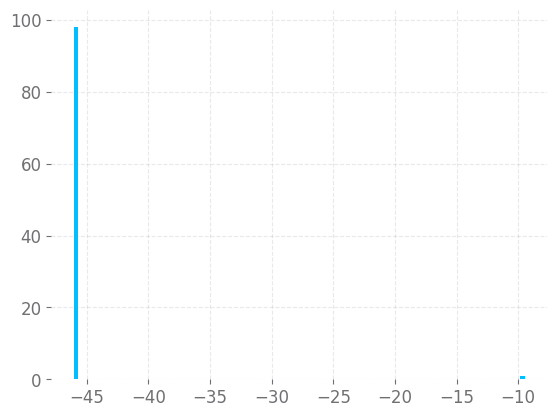

In [13]:
vals, vecs = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, 10000, wt=True)
plt.hist(np.log(vals[1,0]+1e-20), bins=100) #(s,a,eigs)
plt.show()

2023-03-18 19:11:11.942257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:11:11.957255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:11:11.957329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:11:11.958591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:11:11.958655: I tensorflow/compiler/xla/stream_executo

<BarContainer object of 1000 artists>

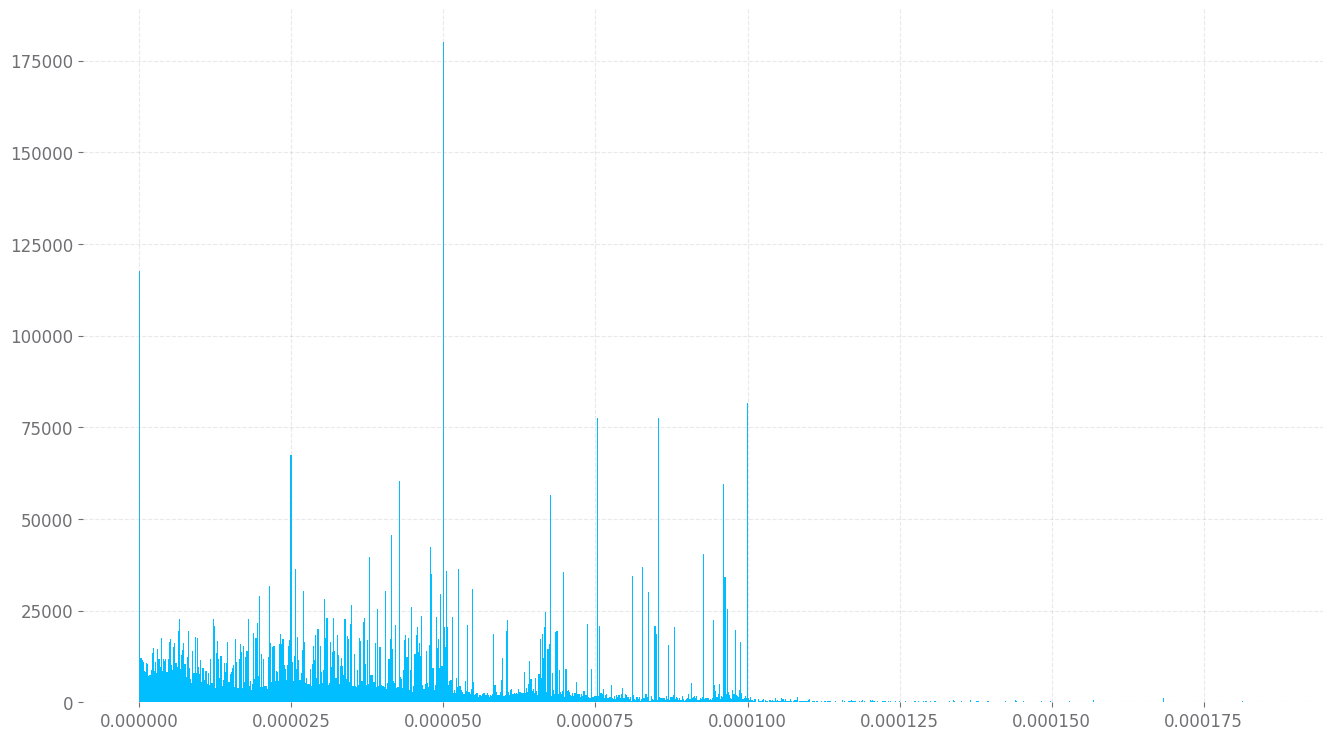

In [12]:
device = "/GPU:0"

hs = np.array([geth(onehotsaclust[:,omegaone,:,:], 
                                     onehotspclust[:,omegaone,:]), 
                              geth(onehotsaclust[:,omegatwo,:,:], 
                                   onehotspclust[:,omegatwo,:])])

statNext = computeStat(hs, 
                      eigvecsa, numpy=False, smalldata=False, device=device, proj=True)

proj1 = (onehotsaclust[:,omegaone,:,:].mean((1,3)) @ eigvecsp)
proj2 = (onehotsaclust[:,omegatwo,:,:].mean((1,3)) @ eigvecsp)
statMC = ((proj1[:,None,:] - proj1[None,...]) * (proj2[:,None,:] - proj2[None,...])).sum(-1)

statmns = 1/statNext.mean() * statNext + 1/statMC.mean() * statMC
statmns = statNext

import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=1000, density=True)[2]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
#sns.kdeplot(statmns.flatten(), bw_adjust=0.5)

<BarContainer object of 1000 artists>

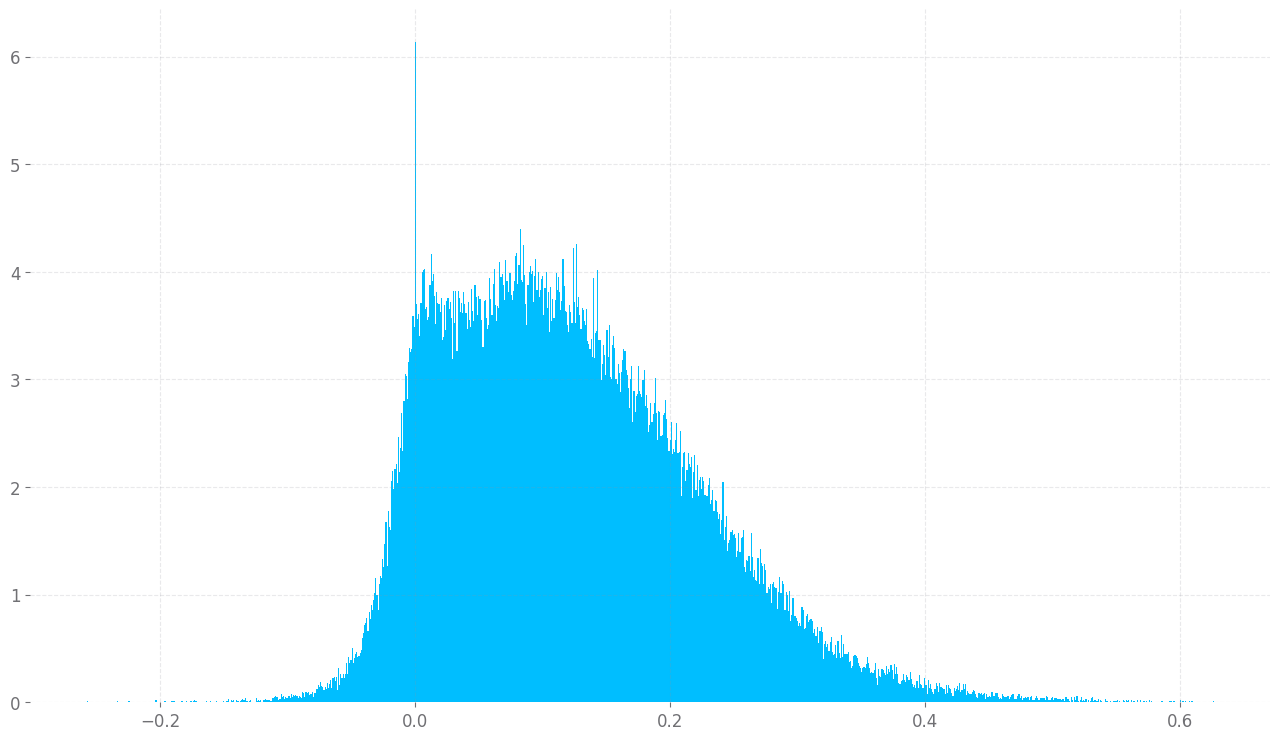

In [20]:
plt.figure(figsize=(16,9))
plt.hist(statMC.flatten(), bins=1000, density=True)[2]

100%|██████████| 100/100 [00:00<00:00, 3482.25it/s]


<BarContainer object of 1000 artists>

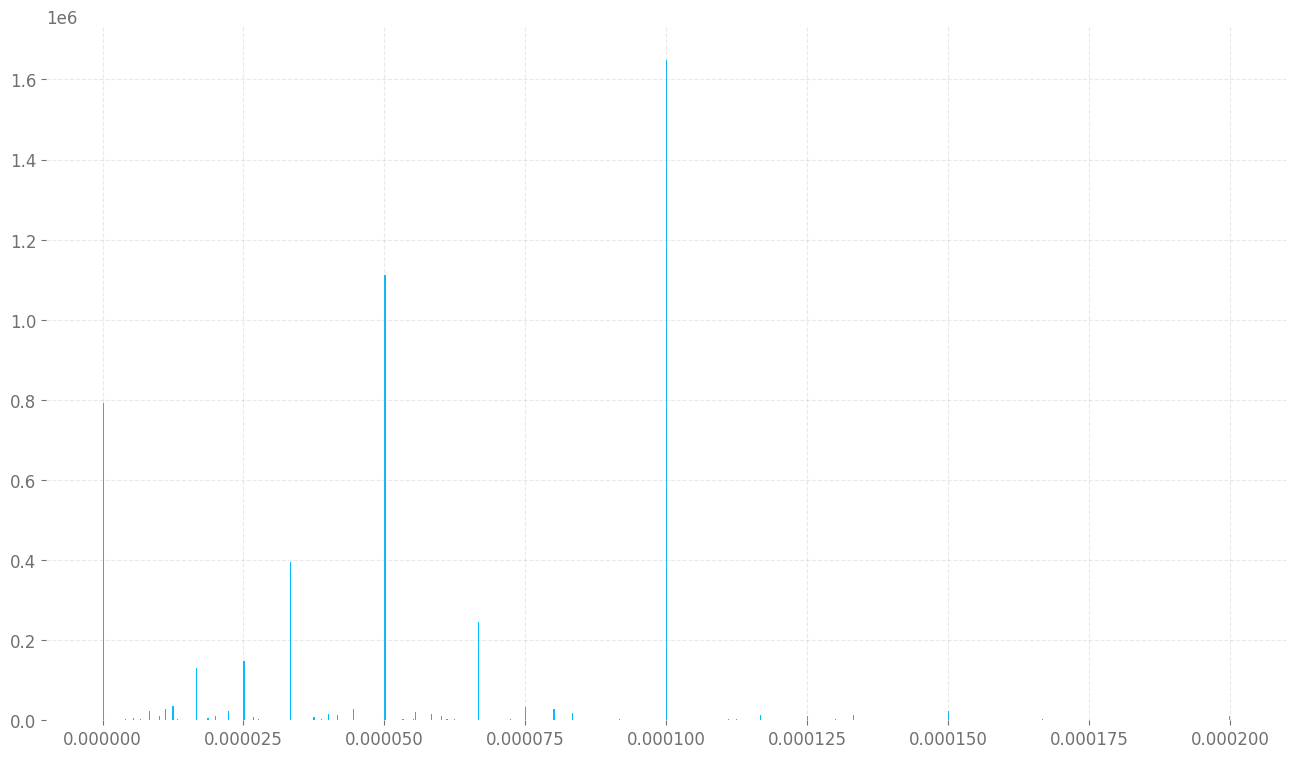

In [21]:
statNoProjs = computeStat(hs, 
                      eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statNoProjs.flatten(), bins=1000, density=True)[2]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
#sns.kdeplot(statmns.flatten(), bw_adjust=0.5)


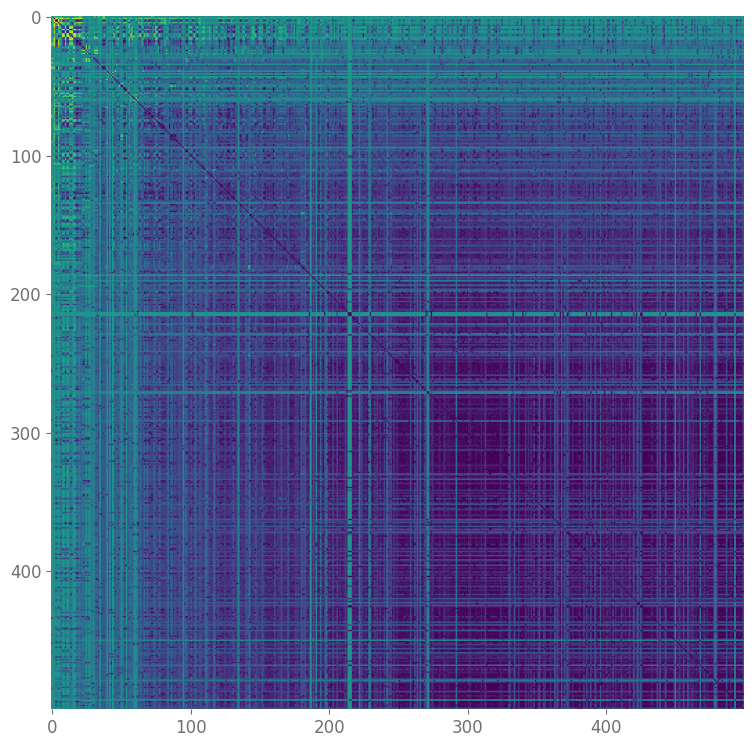

In [13]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|██████████| 41/41 [00:01<00:00, 37.02it/s]


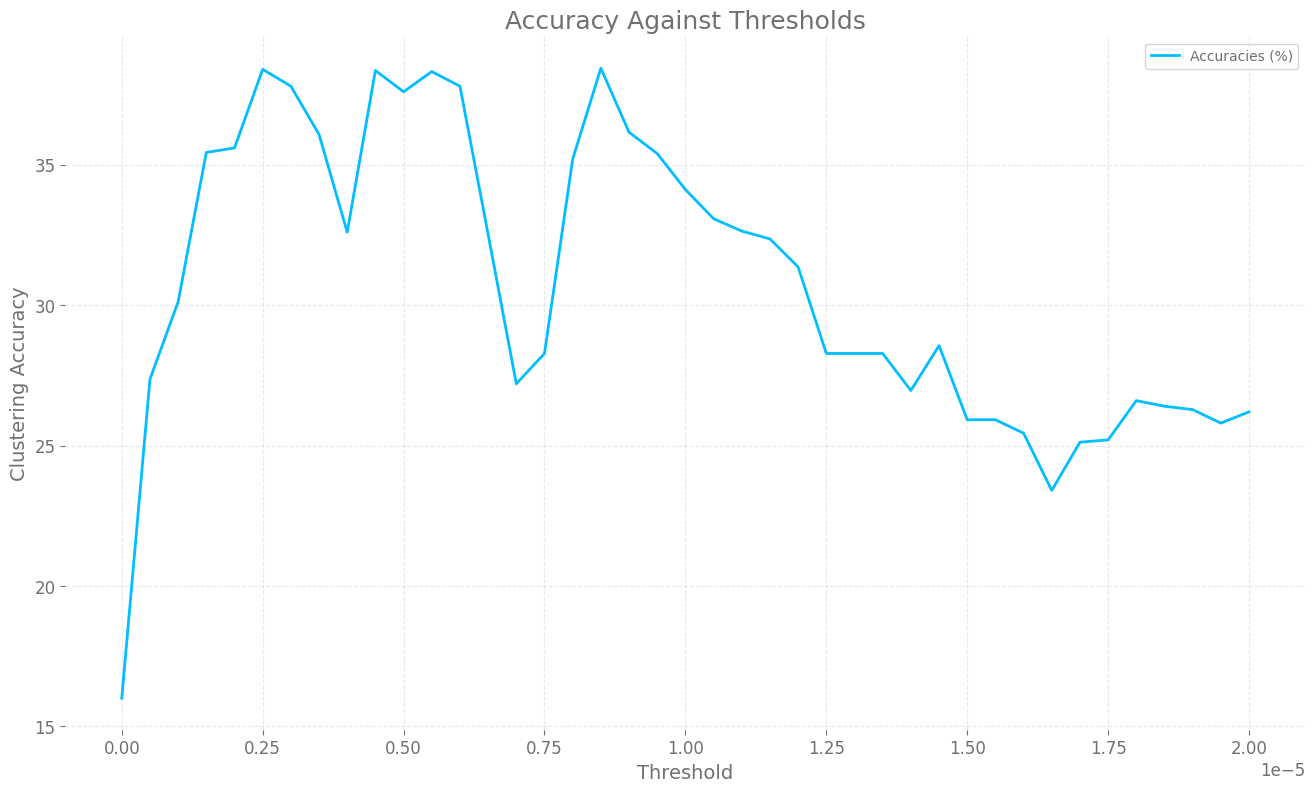

In [20]:
clusterDiagnostics(statmns, K, labels[sz:], lo=0, hi=0.00002, step=0.0000005, trials=5)

100%|██████████| 60/60 [00:05<00:00, 10.35it/s]


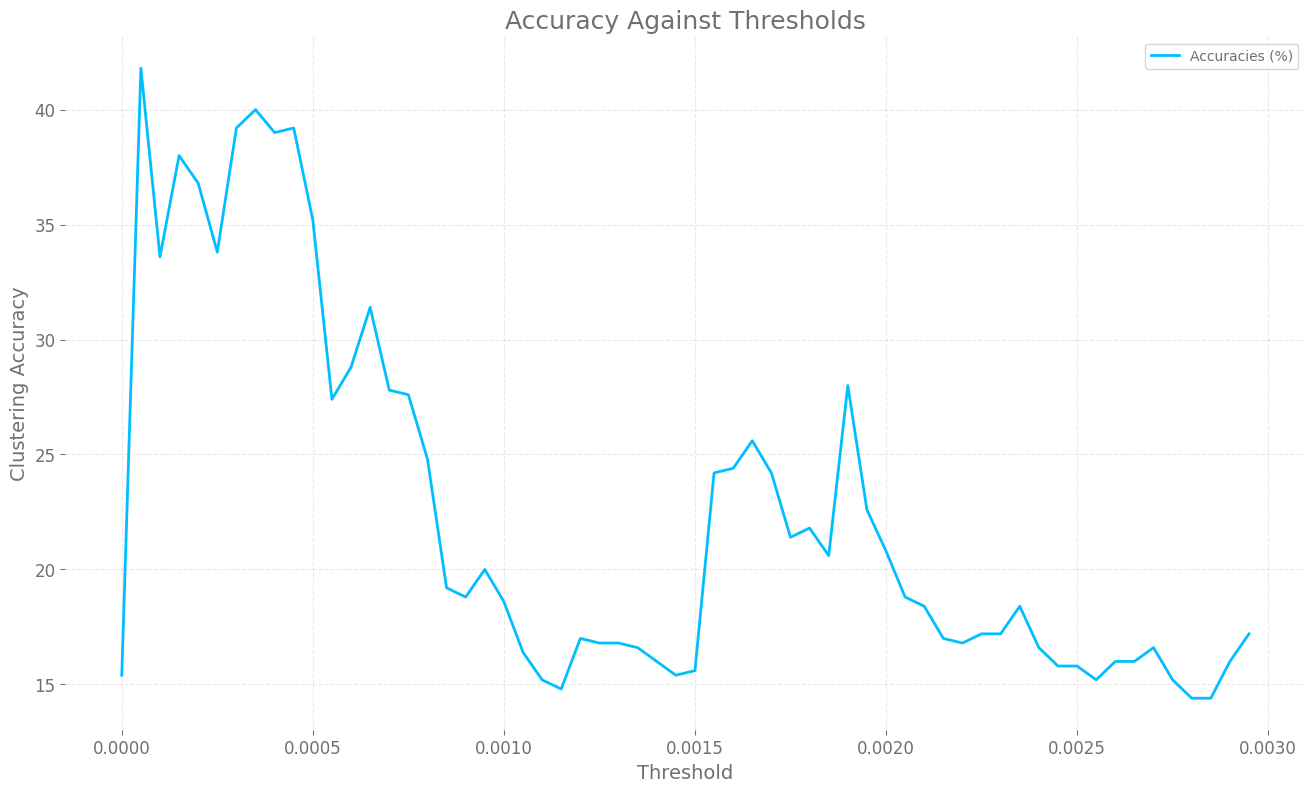

In [193]:
clusterDiagnostics(statmns, K, labels[sz:], lo=0, hi=0.003, step=0.00005, trials=1)

100%|██████████| 40/40 [00:01<00:00, 32.62it/s]


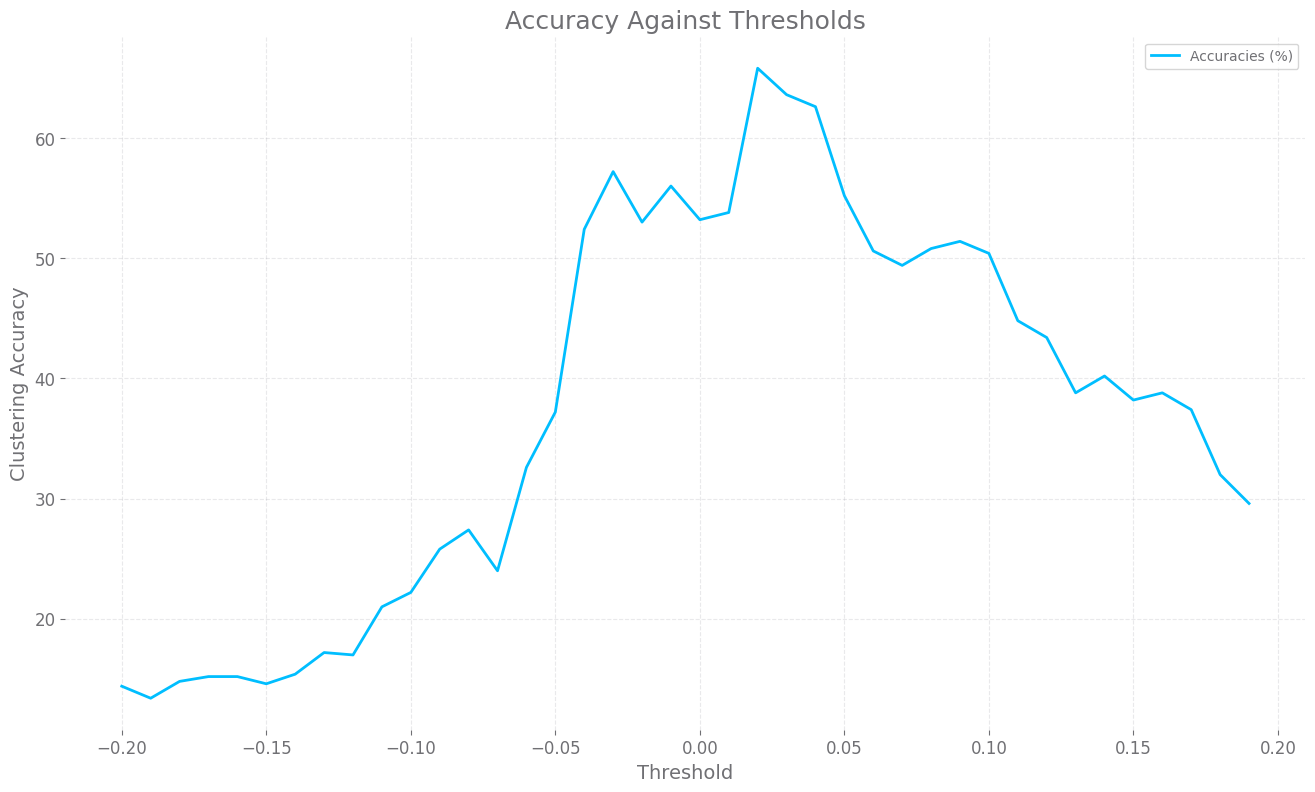

In [133]:
clusterDiagnostics(statMC, K, labels[sz:], lo=-0.2, hi=0.2, step=0.01, trials=1)

100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


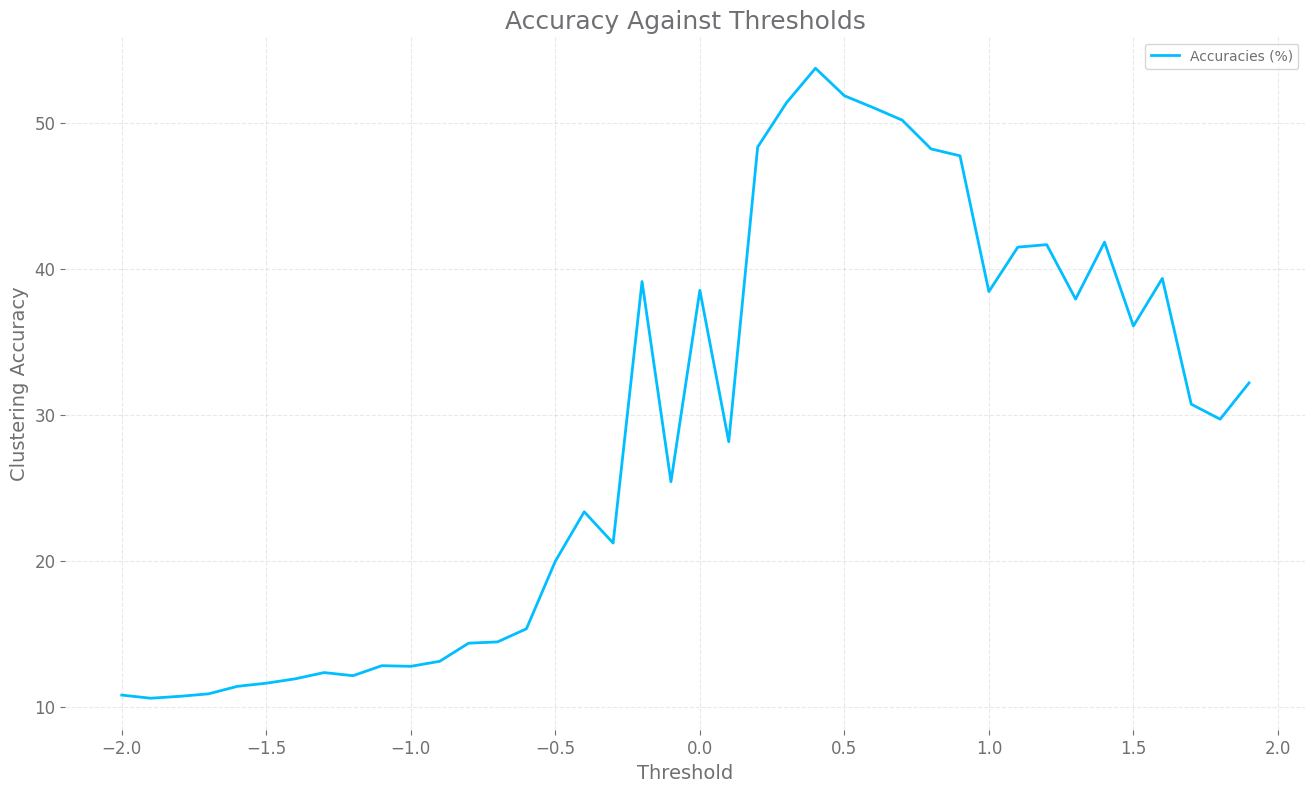

In [161]:
clusterDiagnostics(statmns, K, labels[sz:], lo=-2, hi=2, step=0.1, trials=1)

In [105]:
np.mean([getAcc(sklearn.cluster.spectral_clustering(statmns, n_clusters=K, assign_labels='kmeans'), 
                  labels[sz:]) for i in tqdm(range(10))])

100%|██████████| 10/10 [00:00<00:00, 25.92it/s]


0.23680000000000004

In [106]:
np.mean([getAcc(sklearn.cluster.spectral_clustering(statMC+1, n_clusters=K, assign_labels='kmeans'), 
                  labels[sz:]) for i in tqdm(range(30))])

100%|██████████| 30/30 [00:01<00:00, 28.42it/s]


0.20006666666666675

In [107]:
np.mean([getAcc(sklearn.cluster.spectral_clustering(statNext, n_clusters=K, assign_labels='kmeans'), 
                  labels[sz:]) for i in tqdm(range(30))])

100%|██████████| 30/30 [00:00<00:00, 32.48it/s]


0.2327333333333334

In [108]:
np.median([getAcc(sklearn.cluster.spectral_clustering(statNoProjs, n_clusters=K, assign_labels='kmeans'), 
                  labels[sz:]) for i in tqdm(range(10))])

100%|██████████| 10/10 [00:00<00:00, 28.81it/s]


0.251

In [17]:
actions = np.zeros(states.shape).astype(int)
space = np.linspace(0, 0.002, 30)
clusterlabs = getClusters(statmns, thresh=.5e-5, #0.00035, #1.5e-4, 
                          K=K, method='kmeans')
#clusterlabs = sklearn.cluster.spectral_clustering(statNext, n_clusters=K, assign_labels='kmeans')
getAcc(clusterlabs, labels[sz:])

0.34

In [20]:
np.mean([getAcc(getClusters(statmns, thresh=.5e-5, #1.5e-4, 
                          K=K, method='kmeans'), labels[sz:]) for i in range(30)])

0.32786666666666664

In [22]:
Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:,:], 
                         actions[sz:,:], 
                         nextstates[sz:,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)

In [23]:
priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
piclust = getPolicyEstim(states[sz:], actions[sz:], 
                         K, nStates, nActions, preds=clusterlabs, hard=True)

startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
maxapos = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=1, 
                   prior=priorclass, startweights = startweights, labs=True)
mle = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=0, 
               prior=priorclass, startweights = startweights, labs=True)
mleprobs = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=1, 
                    prior=priorclass, startweights = startweights, labs=False)

getAcc(maxapos[sz:], labels[sz:])

0.334

In [24]:
getAcc(maxapos[:sz], labels[:sz])

0.128

In [26]:
expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states, actions, 
                        nextstates, labels=labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=True,
                                               checkin=1, hard=True)

iteration 1 diff 140.72910990938618
750 750
accuracy: 0.24
-91735.70706997193
iteration 2 diff 2.6904156675357944
750 750
accuracy: 0.24
-91628.93523242336
iteration 3 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
iteration 4 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
iteration 5 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
iteration 6 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
iteration 7 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
iteration 8 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
iteration 9 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
iteration 10 diff 0.0
750 750
accuracy: 0.24
-91628.93523242336
log-likelihood: -91628.93523242336


In [27]:
regprobs = 1*(np.exp(mleprobs)/np.nansum(np.exp(mleprobs), 0)) + 0*np.ones(mleprobs.shape)/K
expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                            Phat_ksa, states, actions, 
                        nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=True, checkin=5, hard=False)

iteration 5 diff 249.3179125689049
750 750
accuracy: 0.24266666666666667
-88205.15643688489
iteration 10 diff 5.007319111214205e-05
750 750
accuracy: 0.24
-88171.93723624776
log-likelihood: -88171.93723624776


In [28]:
randlabs = np.random.choice(K, nTraj)
randmodel = getModelEstim(randlabs, states, actions, nextstates, 
                          K, nStates, nActions, hard=True)
randlabs, randmodel, loglikrand = em(randlabs, randmodel,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=True, checkin=1, hard=True)

iteration 1 diff 0.0
750 750
accuracy: 0.164
-88124.77412740422
iteration 2 diff 9.20838949392398
750 750
accuracy: 0.164
-88048.81086840713
iteration 3 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
iteration 4 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
iteration 5 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
iteration 6 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
iteration 7 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
iteration 8 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
iteration 9 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
iteration 10 diff 0.0
750 750
accuracy: 0.164
-88048.81086840713
log-likelihood: -88048.81086840713


In [29]:
def runif_in_simplex(n, d):
    ''' Return uniformly random vector in the d-simplex '''
    k = np.random.exponential(scale=1.0, size=(n,d))
    return k / k.sum(-1)[:,None]

randlabsoft = runif_in_simplex(nTraj, K).T
randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
randlabsoft, randmodelsoft, loglikrandsoft = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, min_iter = 20, reg = 0, permute=True, permutation=True, checkin=5, hard=False)

iteration 5 diff 113.45599194300843
750 750
accuracy: 0.13733333333333334
-84189.93462891885
iteration 10 diff 1.980388864754266
750 750
accuracy: 0.13733333333333334
-84182.4283037991
iteration 15 diff 0.01699998976899312
750 750
accuracy: 0.13733333333333334
-84181.29901204057
iteration 20 diff 0.008498154210690854
750 750
accuracy: 0.13733333333333334
-84177.01381859917
iteration 25 diff 0.0007320192634505264
750 750
accuracy: 0.13733333333333334
-84176.97758314107
log-likelihood: -84176.97758314107


In [30]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    randlabsoft = runif_in_simplex(nTraj, K).T
    randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
    randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, checkin=1, verbose=False, hard=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)

100%|██████████| 30/30 [00:03<00:00,  8.32it/s]


0.15217777777777777
0.152
0.16666666666666666


Text(0.5, 1.0, 'Randomly Initialized Soft EM Algorithm')

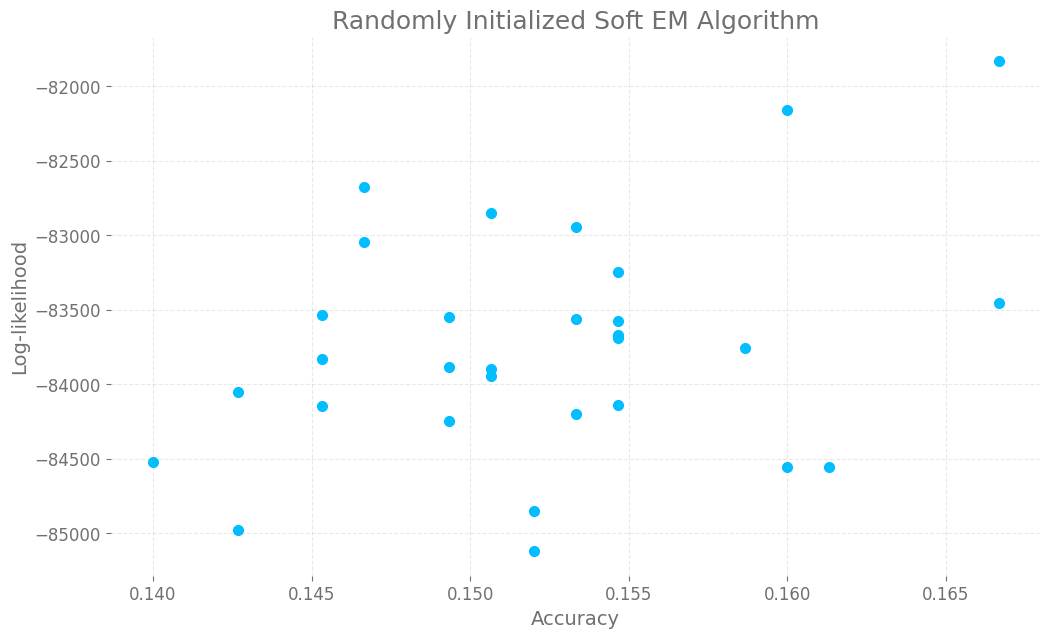

In [31]:
plt.figure(figsize=(12,7))
emAccs = [getAcc(i, labels) for i in np.array(labelsemsoft).argmax(axis=1)]
plt.scatter(emAccs, 
            logliksemsoft)
print(np.mean(emAccs))
print(np.median(emAccs))
print(np.max(emAccs))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')